# Accuracy testing
To test the accuracy of the algorithm, we need some data of which the 'true shift' is known. For this purpose we created a dataset of images with a known relative shift, before adding a variable amount of noise.

In [5]:
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import xarray as xr

from scipy.ndimage.interpolation import shift
from dask.distributed import Client
from Registration import *


client = Client('localhost:8786')
client.upload_file('Registration.py')

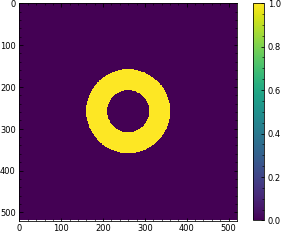

In [3]:
fftsize=256*2 // 2
x,y = np.mgrid[-fftsize-4:fftsize+4,-fftsize-4:fftsize+4]
r_min = 50
r_max = 100
annulus = np.where((r_min**2 < x**2 + y**2) & (x**2 + y**2 < r_max**2), 1., 0.).astype(float)
plt.imshow(annulus)
plt.colorbar();

The $x$ and $y$ coordinate are independent in the algorithm. We take advantage of this by testing two types of displacements at once: a parabolic displacement in the $x$-direction and a random one for $y$.

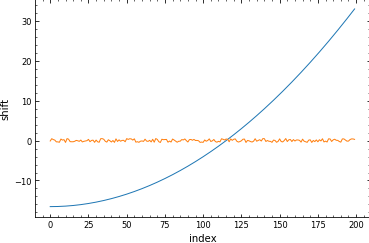

In [4]:
length = 200
x = np.arange(length)
xshifts = x**2/(4*length)
xshifts -= xshifts.mean()
plt.plot(xshifts)
np.random.seed(42)
yshifts = np.random.random(length)
yshifts -= yshifts.mean()
plt.plot(yshifts)
plt.ylabel('shift')
plt.xlabel('index');

Next, we apply the shifts to (copies of the annulus image) to create the dataset

In [ ]:
def syn_shift_blocks(shiftsX, shiftsY, image):
    """Shift copies of image over shiftsX and shiftsY."""
    result = np.stack([image] * dE)
    for index in range(dE): 
        result[index,...] = shift(result[index,...],
              shift=(shiftsX[index,...],shiftsY[index,...]), 
              order=1,
              )
    return result

da_annulus = da.from_array(annulus, chunks='auto' )
xshifts = da.from_array(xshifts[:,np.newaxis,np.newaxis], chunks=(dE,1,1))
yshifts = da.from_array(yshifts[:,np.newaxis,np.newaxis], chunks=(dE,1,1))

synthetic = da.map_blocks(syn_shift_blocks, xshifts, yshifts, da_annulus,
                          dtype=annulus.dtype,
                          chunks=(dE,annulus.shape[0],annulus.shape[1]),
                         )

def only_filter(images, sigma=11, mode='nearest'):
    """Apply the filters.
    Cropped with a margin of sigma,
    to prevent edge effects of the filters."""
    result = images.map_blocks(filter_block, dtype=np.float64, 
                               sigma=sigma, mode=mode)
    if sigma > 0:
        si = int(np.ceil(sigma))
        result = result[:,si:-si,si:-si]
    return result

In [ ]:
# Create the random noise to be added in different magnitudes to the data.
da.random.seed(42)
noise = da.random.normal(size=synthetic.shape, chunks=synthetic.chunks)

In [ ]:
# Create an xarray.DataArray to store the results
As = np.arange(0., 4., 0.05)
sigmas = np.arange(0, 20, 0.25)
ns = np.arange(length)
direction = ['x', 'y']
res = xr.DataArray(np.zeros((len(As), len(sigmas), 2, len(ns))), 
             coords={'A' : As, 's': sigmas, 'direction': direction, 'n': ns}, 
             dims=['A','s', 'direction', 'n'])

In [ ]:
for A in As:
    noisedata = synthetic + A * noise
    noisedata = noisedata.persist()
    for s in sigmas:
        if(res.loc[dict(s=s,A=A,direction='x')].mean() == 0):
            sobel = only_filter(noisedata, 
                                    sigma=s, mode='nearest')
            sobel = sobel - sobel.mean(axis=(1,2), keepdims=True)  
            Corr = dask_cross_corr(sobel)
            weights, argmax = max_and_argmax(Corr)
            Wc, Mc = calculate_halfmatrices(weights, argmax)
            coords = np.arange(Wc.shape[0])*stride + start
            coords, weightmatrix, DX, DY, row_mask = threshold_and_mask(0.0, Wc, Mc, coords=coords)
            dx, dy = calc_shift_vectors(DX, DY, weightmatrix, wpower=4)
            ddx, ddy = [interp_shifts(coords, dx, length).squeeze(), interp_shifts(coords, dy, length).squeeze()]
            res.loc[dict(s=s,A=A,direction='x')] = ddx
            res.loc[dict(s=s,A=A,direction='y')] = ddy
            print(f"A={A}, s={s} completed")
        else: 
            print(f"Skipping A={A}, s={s}")
    res.to_netcdf('accuracy_results.nc')

## Plotting
Let's visualize the results! This produces Figure 8 of the paper.

In [ ]:
data = xr.open_dataset('accuracy_results.nc')
pltdat = np.abs(data['shift'] + trueshifts)
pltdat = pltdat.rename({'s':'$\sigma$'})
pltdat['$\sigma$'].attrs['units'] = 'pixels'
contourkwargs = {'levels': 15, 'colors': 'black', 'alpha': 0.5, 'x':'A'}

maxplotkwargs = {'vmax': 1, 'cbar_kwargs': {'label':'max error (pixels)'}, 'x':'A'}
meanplotkwargs = {'vmax': 1, 'cbar_kwargs': {'label':'mean error (pixels)'}, 'x':'A'}
fig, axs = plt.subplots(ncols=3, nrows=2, 
                        figsize=[8, 4.5], 
                        sharex='col',
                        constrained_layout=True
                       )
axs= axs.T.flatten()

absmax = pltdat.loc['x'].max('n')
# Use imshow to prevent white lines in some PDF-viewers
im = absmax.plot.imshow(ax=axs[0],**maxplotkwargs) 
CS = np.clip(absmax, 0, 1).plot.contour(ax=axs[0],
                                   **contourkwargs)
im.colorbar.add_lines(CS)
axs[0].plot(absmax['A'],
            absmax['$\sigma$'][absmax.argmin(dim='$\sigma$')],  
            '.', color='white')

absmax = pltdat.loc['y'].max('n')
im = absmax.plot.imshow(ax=axs[1], **maxplotkwargs)
CS = np.clip(absmax, 0, 1).plot.contour(ax=axs[1],
                                   **contourkwargs)
im.colorbar.add_lines(CS)
axs[1].plot(absmax['A'], 
            absmax['$\sigma$'][absmax.argmin(dim='$\sigma$')], 
            '.', color='white')

absmean = pltdat.loc['x'].mean('n')
im = absmean.plot.imshow(ax=axs[2], **meanplotkwargs)
CS = np.clip(absmean, 0, 0.29).plot.contour(ax=axs[2],
                                       **contourkwargs)
im.colorbar.add_lines(CS)
axs[2].plot(absmean['A'], 
            absmean['$\sigma$'][absmean.argmin(dim='$\sigma$')],
            '.', color='white')

absmean = pltdat.loc['y'].mean('n')
im = absmean.plot.imshow(ax=axs[3], **meanplotkwargs)
CS = np.clip(absmean, 0, 0.29).plot.contour(ax=axs[3],
                                       **contourkwargs)
im.colorbar.add_lines(CS)
axs[3].plot(absmean['A'], 
            absmean['$\sigma$'][absmean.argmin(dim='$\sigma$')], 
            '.', color='white')

for i,direction in enumerate(['x', 'y']):
    ax = axs[4 + i]
    ax.axhline(1. / length, c='black', alpha=0.5)
    ax.plot(pltdat['A'], pltdat.loc[direction].max('n').min(dim='$\sigma$'), c='black', alpha=0.5)
    optimal = pltdat.loc[direction][{'$\sigma$': pltdat.loc[direction].max('n').argmin(dim='$\sigma$')}]
    ax.fill_between(optimal['A'], *optimal.quantile([0.159, 0.841], dim='n'), color=f'C{i}', alpha=0.7)
    ax.fill_between(optimal['A'], *optimal.quantile([0.023, 0.977], dim='n'), color=f'C{i}', alpha=0.4)
    optimal.mean(dim='n').plot(ax=ax, color='white') # marker='.')
    optimal.max(dim='n').plot(ax=ax, c='gray')
    pltdat.loc[direction].max('n').min(dim='$\sigma$')

for ax in axs:
    ax.set_xlim([0,1.95])
for ax in axs[:4]:
    ax.set_ylim([0, 10.8])
for ax in axs[4:]:
    ax.set_ylim([0, max(axs[4].get_ylim()[1], axs[5].get_ylim()[1])])
    ax.yaxis.set_label_position("right")
    ax.tick_params(axis='y', labelright=True, labelleft=False)
    ax.set_ylabel("Error (pixels)")
for ax in axs[1::2]:
    ax.set_title(None)
for ax in axs[::2]:
    ax.set_xlabel(None)
axs[0].set_title("Max error")
axs[2].set_title("Mean error")
axs[4].set_title("Optimal error spread")
    

plt.savefig('simulation_error.pdf')